# 1K1K validation

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path  = '/data_volume/memento/lupus/'

### Read SNP positions

In [4]:
pos = pd.read_csv(data_path + 'cm_cg.genos', sep='\t', index_col=0)

In [5]:
pos = pos[~pos.index.duplicated(keep='first')]

In [6]:
# Filter for lupus patients
pos = pos[[c for c in pos.columns if 'HC' not in c]]

### Read mat eQTL output

In [7]:
cbc_eqtls = pd.read_csv(data_path + 'Table6.txt', sep='\t', skiprows=1).query('cell == "cm"').drop('STD_FE', axis=1)
cbc_eqtls.columns = ['ct', 'rsid_gene', 'pvalue', 'beta']

In [8]:
cbc_eqtls['gene'] = cbc_eqtls['rsid_gene'].str.split('_').str[1]
cbc_eqtls['rsid'] = cbc_eqtls['rsid_gene'].str.split('_').str[0]

In [9]:
cbc_eqtls = cbc_eqtls[cbc_eqtls['rsid'].isin(pos.index)]

### Read 1K1K eQTL output

In [10]:
onek1k_pos = pd.read_csv('1k1k_snps_chrpos.txt', header=None).iloc[:,0].tolist()
onek1k_info = pd.read_csv('1k1k_snp_info.txt', sep='\t', header=None).iloc[:,:3]
onek1k_info.columns = ['chr', 'pos', 'name']
onek1k_info['rsid'] = onek1k_info['chr'].astype(str) + ':' + onek1k_info['pos'].astype(str)

In [11]:
onek_replication = pd.read_csv(data_path + 'OneK1K_eqtls_for_replication.txt', sep='\t')#.query('cell_type == "Mono_C"')

In [12]:
onek_replication = onek_replication.merge(onek1k_info, left_on='SNP_rsID', right_on='name').query('cell_type == "Mono_C"')

In [20]:
onek_replication['gene'] = onek_replication['GeneID']
onek_replication['hit_id'] = onek_replication['gene'] + '*' + onek_replication['rsid']

In [21]:
cbc_eqtls['hit_id'] = cbc_eqtls['gene'] + '*' + cbc_eqtls['rsid']

In [23]:
cbc_eqtls['onek_valid'] = cbc_eqtls['hit_id'].isin(onek_replication['hit_id'])

In [24]:
cbc_eqtls['onek_valid'].sum()

213

In [25]:
cbc_eqtls['logp'] = -np.log10(cbc_eqtls['pvalue'])

<AxesSubplot:xlabel='onek_valid', ylabel='beta'>

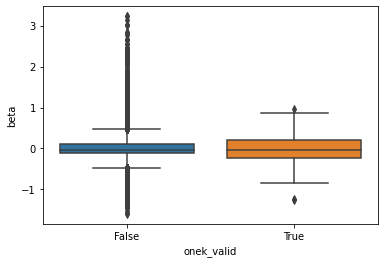

In [45]:
sns.boxplot(x='onek_valid', y='beta', data=cbc_eqtls)


In [31]:
memento_eqtls = pd.read_csv(data_path + 'cbc_eqtl_memento.csv')

In [33]:
memento_eqtls['hit_id'] = memento_eqtls['gene'] + '*' + memento_eqtls['rsid']

In [34]:
memento_eqtls['onek_valid'] = memento_eqtls['hit_id'].isin(onek_replication['hit_id'])

In [35]:
memento_eqtls['onek_valid'].sum()

200

In [37]:
memento_eqtls['logp'] = -np.log10(memento_eqtls['de_pval'])

<AxesSubplot:xlabel='onek_valid', ylabel='de_coef'>

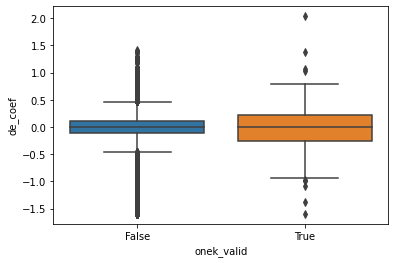

In [44]:
sns.boxplot(x='onek_valid', y='de_coef', data=memento_eqtls)
# plt.ylim(0, 11)

In [41]:
stats.ranksums(cbc_eqtls.query('onek_valid')['logp'], cbc_eqtls.query('~onek_valid')['logp'])

RanksumsResult(statistic=18.480686419153734, pvalue=2.953991840505631e-76)

In [42]:
stats.ranksums(memento_eqtls.query('onek_valid')['logp'], memento_eqtls.query('~onek_valid')['logp'])

RanksumsResult(statistic=11.791984424643477, pvalue=4.2930463856061386e-32)